In [2]:
import numpy as np
import cv2
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
IMAGE_SHAPE = (224, 224)

Charger le modèle (MobileNet) depuis TensorFlow Hub

[Documentation](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5)

In [5]:
mobile_net_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5", input_shape=IMAGE_SHAPE + (3,))
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


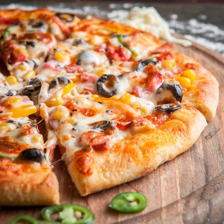

In [6]:
img_pizza = Image.open("pizza.jpg").resize(IMAGE_SHAPE)
img_pizza

Scaling (normalisation)

Attribuer à chaque pixel de l'image, une valeur comprise entre 0 et 1.

In [7]:
img_pizza = np.array(img_pizza)/255.0
# img_pizza

On lance la prédiction

In [8]:
# img_pizza[np.newaxis, ...].shape
all_predictions = mobile_net_model.predict(img_pizza[np.newaxis, ...])
# Les prédictions pour l'esemble des classes (environ 1000) que possède le modèle
all_predictions

1/1 [==============================] - 2s 2s/step


array([[ 0.33532038, -0.68237656,  0.90563   , ...,  1.061515  ,
         1.9954362 , -0.2648571 ]], dtype=float32)

À quel index de `all_predictions` se trouve la prédiction avec la valeur la plus élevée ?

In [9]:
prediction_index = np.argmax(all_predictions)
prediction_index

964

À quelle classe correspond l'index ?

In [10]:
labels = []
with open("ImageNetLabels.txt", "r") as f:
    labels = f.read().splitlines()

In [11]:
classe = labels[prediction_index]
classe

'pizza'

In [12]:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url,  cache_dir=".", untar=True)
# cache_dir indique où stocker les données.
# untar=True va permettre de décompresser le fichier

In [13]:
data_dir = "..\\data\\flower_photos"

In [14]:
import pathlib

data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('../data/flower_photos')

In [15]:
img_paths = list(data_dir.glob("*/*.jpg"))
# "*/*.jpg" => 
#   on parcoure de manière récursive tous les fichiers et on récupère les chemins d'accès de chacune des images (*.jpg)
img_paths[:5]

[WindowsPath('../data/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('../data/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('../data/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('../data/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('../data/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [16]:
roses_path = list(data_dir.glob("roses/*.jpg"))
roses_path[:5]

[WindowsPath('../data/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('../data/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('../data/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('../data/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('../data/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

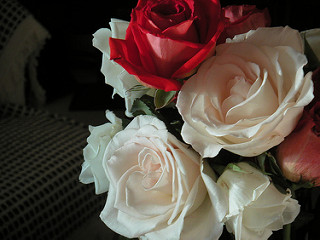

In [17]:
img_rose = Image.open(str(roses_path[1]))
img_rose

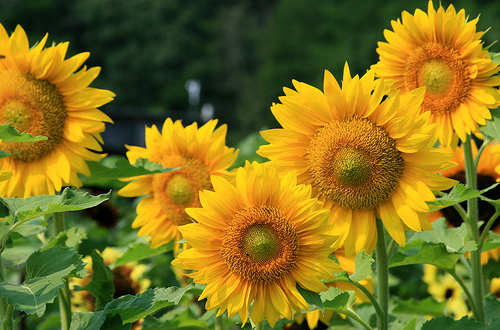

In [18]:
def img_dictionnaire(*keys):
    dictionnaire = {}

    for key in keys:
        dictionnaire[key] = list(data_dir.glob(f"{key}/*.jpg"))

    return dictionnaire

flowers_img_paths = img_dictionnaire("roses", "daisy", "dandelion", "sunflowers", "tulips")

sunflower_path = flowers_img_paths["sunflowers"][0]
img_sunflower = Image.open(sunflower_path)
img_sunflower

In [19]:
def labels_dictionnaire(*keys):
    dictionnaire = {}

    for key_index, key in enumerate(keys):
        dictionnaire[key] = key_index

    return dictionnaire

flowers_labels_dict = labels_dictionnaire("roses", "daisy", "dandelion", "sunflowers", "tulips")
flowers_labels_dict

{'roses': 0, 'daisy': 1, 'dandelion': 2, 'sunflowers': 3, 'tulips': 4}

In [20]:
# équivalent à Image.open()
# ici, en revanche,
# l'image sera transposée sous forme de tableaux (un élément du tableau corrapondant à une valeur RGB d'un pixel)
# et on aura accès à des informations sur l'image (shape, ...)
# en argument on a objet de type `str` et non pas `WindowsPath`
tulip_path = flowers_img_paths["tulips"][0]
img_tulip = cv2.imread(str(tulip_path))
img_tulip.shape

(209, 320, 3)

On récupère une image redimensionnée

In [21]:
resized_img_tulip = cv2.resize(img_tulip, IMAGE_SHAPE)
resized_img_tulip.shape

(224, 224, 3)

In [22]:
# flowers_img_paths.items()

In [24]:
resized_images, img_labels = [], []

for flower_name, img_paths in flowers_img_paths.items():
    for img_path in img_paths:
        img = cv2.imread(str(img_path))
        resized_image = cv2.resize(img, IMAGE_SHAPE)

        resized_images.append(resized_image)
        img_labels.append(flowers_labels_dict[flower_name])


on convertit les tableaux 'resized_images' et 'img_labels' en np array afin de pouvoir faire facilement des calculs (normalisation, ...) sur l'ensemble des images transposées

In [25]:
resized_images = np.array(resized_images)
img_labels = np.array(img_labels)

on split le dataset en 2 (train et test)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(resized_images, img_labels, random_state=0)

rescaling of train and test datasets

In [27]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Essayons de voir ce que predit le modèle pré-entrainé pour certaines images de notre dataset de fleurs

***Note :*** OpenCV utilise les canaux BGR et non pas RGB. Les images apparaisent alors avec les mauvaises couleurs.

Pour afficher les images avec les bonnes couleurs, utiliser le code suivant : `cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`

La première image :

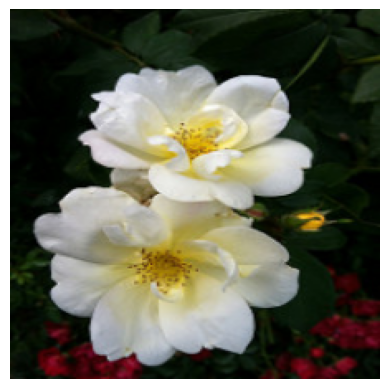

In [28]:
plt.axis("off")
# plt.imshow(resized_images[0])
plt.imshow(cv2.cvtColor(resized_images[0], cv2.COLOR_BGR2RGB))

La deuxième image :

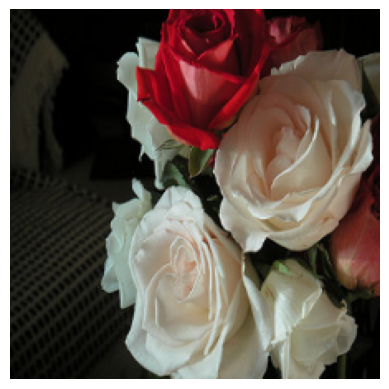

In [29]:
plt.axis("off")
# plt.imshow(resized_images[1])
plt.imshow(cv2.cvtColor(resized_images[1], cv2.COLOR_BGR2RGB))

In [30]:
predictions = mobile_net_model.predict(np.array([resized_images[0], resized_images[1]]))
predictions = np.argmax(predictions, axis=1)
predictions

1/1 [==============================] - 2s 2s/step


array([795, 880], dtype=int64)

In [31]:
print(labels[795])
print(labels[880])

shower curtain
umbrella


Les prédictions ne sont pas terribles. Ce qui est normal.

Maintenant, on va prendre le modèle pré-entrainé et on va l'entrainer avec les images de fleurs

In [32]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [33]:
num_of_flowers = 5

my_model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    # on ajoute la dernière couche de neuronne (celle qui va être entrainée)
    tf.keras.layers.Dense(num_of_flowers)
])

my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


on compile le modèle

In [34]:
my_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["acc"])

my_model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 62s 619ms/step - loss: 0.8184 - acc: 0.6959
Epoch 2/5
86/86 [==============================] - 53s 619ms/step - loss: 0.4068 - acc: 0.8637
Epoch 3/5
86/86 [==============================] - 56s 650ms/step - loss: 0.3194 - acc: 0.8950
Epoch 4/5
86/86 [==============================] - 53s 609ms/step - loss: 0.2636 - acc: 0.9204
Epoch 5/5
86/86 [==============================] - 56s 653ms/step - loss: 0.2263 - acc: 0.9320


Quelles sont les nouvelles prédictions sur notre dataset de fleurs ?

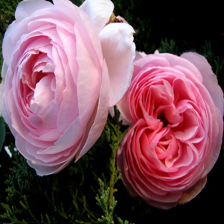

In [72]:
img_rose = Image.open("rose.jpg").resize(IMAGE_SHAPE)
img_rose

In [73]:
img_rose = np.array(img_rose)/255.0

In [74]:
rose_predictions = my_model.predict(img_rose[np.newaxis, ...])
# rose_predictions
# print(np.argmax(rose_predictions))
i = np.argmax(rose_predictions)
print(list(flowers_labels_dict.keys())[i])

1/1 [==============================] - 0s 58ms/step
roses


In [55]:
my_model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 18s 613ms/step - loss: 0.3884 - acc: 0.8682


[0.38844752311706543, 0.8681917190551758]

In [56]:
my_model.evaluate(X_train_scaled, y_train)

86/86 [==============================] - 53s 599ms/step - loss: 0.2066 - acc: 0.9404


[0.20664502680301666, 0.9404069781303406]